# Double Descent in Linear Regression

This notebook is based on a recent [paper](https://arxiv.org/abs/1912.02292) that observed a phenomenon dubbed "(model-based) double descent". To understand this idea, consider the bias-variance tradeoff from classical statistics. Roughly this says that as you increase the number of parameters in a model, the bias decreases at the cost of increasing the variance. This tells you to expect that as you increase model complexity by more parameters you should expect worse generalization since the model memorizes the data. On the contrary, it has been pointed out in this paper and references therein that test performance actually becomes better again after becoming worse. This notebook explores this effect.

In [181]:
# basics
import numpy as np
import matplotlib.pyplot as plt

# train/test split
from sklearn.model_selection import train_test_split

# tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

In [189]:
# Generate x values
xmin = -0.5
xmax = 0.5
dx = 0.01
X = np.arange(xmin, xmax, dx)

# generate y-values
period = 0.5

def true_model(x, period):
    return 0.3*np.sin(2*np.pi*x/period) + x

y = true_model(X, period)

In [190]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

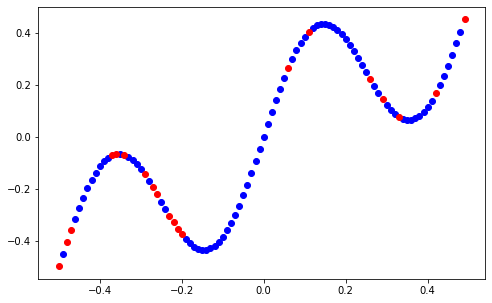

In [191]:
plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, c="blue")
plt.scatter(X_test, y_test, c="red")

# Classical U-shape

The first goal will be to see the "U"-shape in the test loss as a function of the model complexity.

In [192]:
def compute_powers(X, num_powers):
    """takes a 1D numpy array of length N and returns a 2D numpy array of shape (N, num_powers)
    where """
    
    new_X = np.zeros((len(X), num_powers))
    
    for i in range(num_powers):
        new_X[:, i] = X**(i+1)
        
    return new_X

def train_test_loss(X_train, y_train, X_test, y_test, num_params, num_epochs, output_model=False):
    """ Compute the train/test loss from a polynomial regression."""
    
    # get powers of X_train
    new_X_train = compute_powers(X_train, num_params)
    new_X_test = compute_powers(X_test, num_params)
    
    model = Sequential()
    
    model.add(Dense(1, input_shape=(num_params,)))
#                     kernel_regularizer=l2(0.0001)))
    optimizer = SGD(learning_rate=0.1)
    model.compile(loss='mae',
                 optimizer=optimizer)
    
    model.fit(new_X_train, y_train, epochs=num_epochs, verbose=0)
    
    train_loss = model.evaluate(new_X_train, y_train, verbose=0)
    test_loss = model.evaluate(new_X_test, y_test, verbose=0)
    
    if output_model:
        return model
    
    return train_loss, test_loss


In [193]:
train_test_loss(X_train, y_train, X_test, y_test, num_params=2, num_epochs=20)

(0.18351443111896515, 0.17054617404937744)

In [199]:
num_params_debug=10

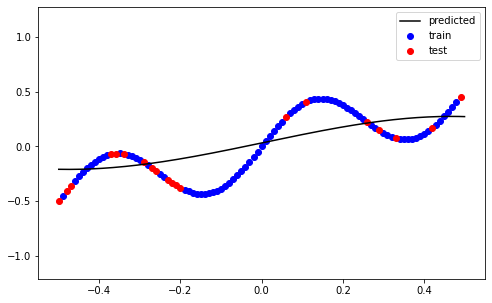

In [200]:
def plot_model(model, domain=X, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, num_params=num_params_debug,
              data=True):
    """plot the tensorflow model on the given domain. Make sure 
    num_params is equal to the number of parameters from the model."""
    
    model_values = model.predict(compute_powers(domain, num_params_debug))
    
    plt.figure(figsize=(8,5))
    if data:
        plt.scatter(X_train, y_train, c="blue", label="train")
        plt.scatter(X_test, y_test, c="red", label="test")
    plt.plot(domain, model_values, c="black", label="predicted")
    plt.ylim(np.min(model_values)-1, np.max(model_values)+1)
    plt.legend()
    plt.show()
    
    
model_1 = train_test_loss(X_train, y_train, X_test, y_test, num_params=num_params_debug, num_epochs=1000, output_model=True)
plot_model(model_1, domain=np.linspace(xmin, xmax, 300), data=True)